In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

In [2]:
torch.set_default_dtype(torch.float64)

**Class: OU processes**

In [78]:
class OU_vector:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN, D, timegrid='True'):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha

        """
            check whether every element in sigma is positive
        """
        assert all(beta > 0), "beta should be positive"    
        self.beta = beta
        assert all(sigma > 0), "variance should be positive"
        self.sigma = sigma
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
                Make sure to match the dimension of each object;
                    note that memoryview of torch/python object flattens
        """
        output = torch.empty(self.pts.shape)
        output[:, 0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        for t in range(1, self.pts.shape[1]):
            dt = interval[:, t-1].reshape(-1, 1)
            mean = self.alpha + (output[:, t-1].reshape(-1,1) - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean.flatten(), cov = torch.diag(var.flatten())))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
        return output, interval

In [146]:
D = 2

In [173]:
alpha = torch.tensor(10.).repeat(D, 1)
beta = torch.tensor([1.,2.]).reshape(-1,1)
z0 = torch.randn((D, 1))
sigma = torch.tensor(1.).repeat(D,1)

**Note that the diffusion simulation based on Euler-Maruyama results in very smooth plot once dt > 2.**

In [174]:
true_sde = OU_vector(t0 = 3., t1 = 4., z0 = z0, alpha = alpha, beta = beta, sigma = sigma, dN=300, D = D, timegrid='True')

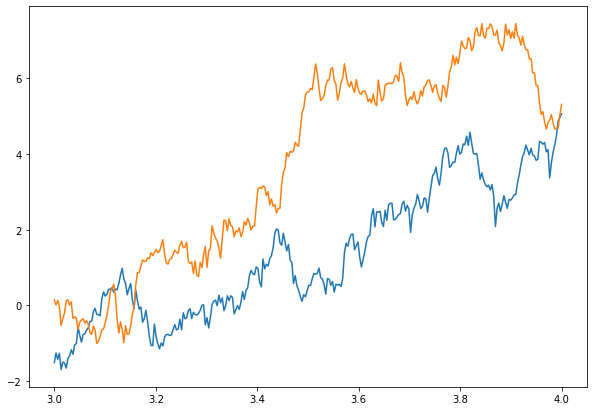

In [175]:
plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T)
plt.show()

Variational inference: KL

In [111]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        # Hyperparameter
        sigma = self.ou.sigma
        
        # Parameters
        assert all(beta > 0), "beta should be positive"
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the likelihood based on the transition density of the (simulated) path
            """
#             print("sigma = ", sigma.shape, "beta = ", beta.shape, "dt = ", dt.shape)
#             print("log sigma = ", torch.log(sigma), "log beta = ", torch.log(beta), "rest = ", torch.log(1 - torch.exp(-2 * beta * dt)) )
            term1 = -0.5 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = beta * (X[:, 1:] - alpha - (X[:, :-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))
#             print("term1 = ", term1, "term2 = ", term2, "term3 = ", term3)
            return torch.sum(term1 - term2/term3, axis=1)
        
        LL = compute_transition(X, dt, alpha, beta, sigma)
#         print(LL.data.numpy())
#         print("D = ", self.ou.D)
        LL.backward(torch.tensor([1.]).repeat(self.ou.D))
         
        return {"alpha": alpha.grad.detach().clone(), 'beta':beta.grad.detach().clone(), "LL": LL.data.numpy()}


In [179]:
alpha_ = torch.randn((2, 1))
beta_ = torch.tensor([5., 5.]).reshape(-1,1)


learning_rate = 0.05

for i in range(10000):
    lr = 0.1
    mle = Score(true_sde)
    update = mle.compute_score(alpha = alpha_, beta=beta_)
    
    alpha_ += learning_rate * update['alpha']
    beta__ =  beta_ + learning_rate * update['beta']
    
    
    while any(beta__ < 0):
        for d in range(beta_.shape[0]):
            if beta__[d] < 0:
                while beta__[d] < 0:
                    beta__[d] = beta_[d] + lr * update['beta'][d]
                    lr *= 0.5
    beta_ = beta__
    if i % 1000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'LL = ', update['LL'])

beta =  [[3.7851927 ]
 [0.91376807]] alpha =  [[3.20461118]
 [5.70173906]] LL =  [-1862.1175871  -1929.22031458]
beta =  [[1.71909951]
 [0.8265474 ]] alpha =  [[7.05091293]
 [9.24359636]] LL =  [-1782.29978325 -1687.8098491 ]
beta =  [[1.63266613]
 [0.74791523]] alpha =  [[7.5224128 ]
 [9.40693261]] LL =  [-1775.41154019 -1688.0174244 ]
beta =  [[1.14053024]
 [0.76370146]] alpha =  [[7.77968769]
 [9.39108137]] LL =  [-1766.64100975 -1687.95347601]
beta =  [[1.00603256]
 [0.76352987]] alpha =  [[7.32323648]
 [9.39382988]] LL =  [-1766.20480716 -1687.95163518]
beta =  [[0.9908297 ]
 [0.76332651]] alpha =  [[7.68475136]
 [9.39355414]] LL =  [-1765.96838272 -1687.95289115]
beta =  [[1.78460311]
 [0.76336564]] alpha =  [[7.19480005]
 [9.39356469]] LL =  [-1783.08767832 -1687.95269062]
beta =  [[0.99701433]
 [0.76336143]] alpha =  [[7.4527359 ]
 [9.39356676]] LL =  [-1766.10909957 -1687.95270909]
beta =  [[1.38674219]
 [0.76336163]] alpha =  [[7.96135074]
 [9.39356623]] LL =  [-1769.10270535

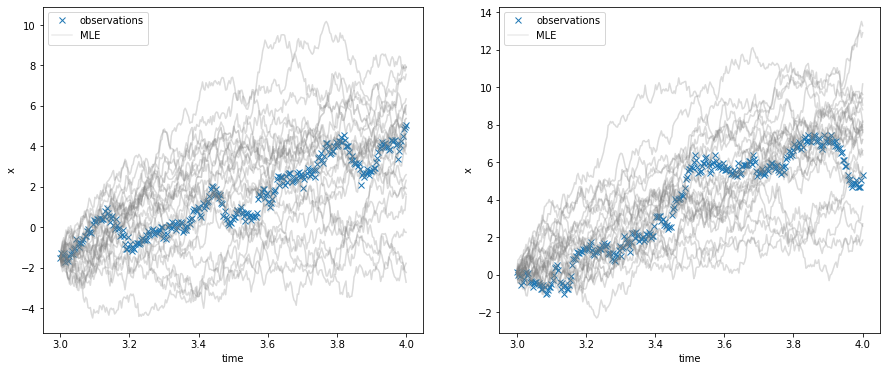

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
# plt.title("Fitted Process: MLE")
for j, ax in enumerate(ax.ravel()):
    ax.plot(true_sde.pts[j], true_sde.trj[j], 'x', label='observations')
    for i in range(25):
        vi = OU_vector(t0 = 3., t1 = 4., z0 = z0, alpha = alpha_, beta = beta_, sigma = sigma, dN=300, D = D, timegrid='True')    
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey')
        if i == 24:
            ax.plot(vi.pts[j], vi.trj[j], alpha=0.15, color='grey', label='MLE')
    ax.set_xlabel("time")
    ax.set_ylabel("x")
    ax.legend()
plt.show()

In [181]:
print("True alpha = \n", alpha.data.numpy(), "\nAlpha_MLE = \n", alpha_.data.numpy(), "\nTrue Beta = \n", beta.data.numpy(), "\nBeta_MLE = \n", beta_.data.numpy())

True alpha = 
 [[10.]
 [10.]] 
Alpha_MLE = 
 [[7.3118392 ]
 [9.42561613]] 
True Beta = 
 [[1.]
 [2.]] 
Beta_MLE = 
 [[0.858499  ]
 [1.01666054]]


In [ ]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)
        return ((beta ** 2) - 1 ) / 2  * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(u):
            return (u ** 2) / 2
        
        return (1 + beta) * (A(z1) - A(z0) - ((t1 - t0) / 2))
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [ ]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = False)
        m0 = Variable(m0, requires_grad = True)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'m0':m0.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

In [ ]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = Variable(beta, requires_grad=True)
        dt = self.ou.dt
        X = self.ou.trj

        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (- torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
        
        return {'beta':beta.grad.detach().clone()}
    
    def LLN(self, beta):
        alpha = torch.tensor(self.ou.alpha)
        sigma = torch.tensor(self.ou.sigma)
        beta = torch.tensor(beta)
        dt = self.ou.dt
        X = self.ou.trj
        """
        Compute the transition density of the (simulated) path
        """
        term1 = -1/2 * ( - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
        term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
        term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

        return torch.sum(term1 + term2/term3)

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [ ]:
true_sde = OU(t0 = 0, t1 = 10., z0 = -1, alpha = 0, beta = 5., sigma = 1., dN=1000)

In [ ]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % true_sde.alpha + ", beta = %.2f" % true_sde.beta + ", sigma = %.2f" % true_sde.sigma)
plt.show()

In [ ]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

In [ ]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [ ]:
import tqdm as tq

In [ ]:
beta_ = 2.

N = 50
learning_rate = 0.00001

trace_beta = []
trace_elbo = []
for i in tq.tqdm(range(1000)):
# for i in range(300):
    beta_grad = 0.

    for i in range(N):
        vi = OU(t0 = obs_time[8], t1 = obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[9]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
     
    beta_ -= learning_rate * (beta_grad/N).numpy()
    
    elbo_estimate = 0
    for j in range(50):
        vi_ = OU(t0 = obs_time[8], t1=obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[9]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/100
    
    trace_beta.append(beta_)
    trace_elbo.append(elbo_estimate)
# score.compute_score()

In [ ]:
for i in range(50):
    posterior = OU(t0 = obs_time[8], t1 = obs_time[9], z0 = obs[8], alpha = 0 , beta = beta_ , sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [ ]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace_beta)), trace_beta)
plt.axhline(1.0, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

Trace plot: ELBO

In [ ]:
plt.title("Trace plot: (Negative) ELBO")
plt.plot(np.arange(len(trace_elbo)), trace_elbo)
plt.xlabel("iteration")
plt.ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [ ]:
def posterior_moment(init, alpha, beta):
    sigma = 1.
    pts = np.linspace(0,1,100)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [ ]:
pmean, psd = posterior_moment(obs[8], 0, beta_)

In [ ]:
plt.plot(true_sde.pts, true_sde.trj, linestyle='dashed', label='underlying sde')
plt.plot(true_sde.pts[800:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[801:900], pmean[1:] - psd, pmean[1:] + psd, alpha=0.3, color='grey')
plt.plot(obs, 'rx', label='observations')
plt.legend()
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [ ]:
N = 50
N_e = 50
learning_rate = 0.00002
z0 = obs[0]
vi_beta = np.empty(9)
IT = 300

elbo_traces = np.empty((9, IT))
beta_traces = np.empty((9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(0, 1)
    
    trace = []
    for i in range(IT):
        beta_grad = 0.
            
        for k in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(beta_, dtype=torch.float64))
            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']

        beta_ -= learning_rate * (beta_grad/N).numpy()
        beta_traces[t, i] = beta_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = OU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 100 == 0:
            print("beta = ", beta_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    vi_beta[t] = np.mean(beta_traces[t, -30:])
    
    z0 *= np.exp(-1 * vi_beta[t] * (obs_time[t+1] - obs_time[t]))
    
# score.compute_score()

Trace plot: ELBO

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(beta_traces[t, :IT])), beta_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [ ]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [ ]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 10)

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Sanity check: score function**
This code is to examine whether the gradient descent with the above score class gives a plausible MLE 

In [ ]:
torch.set_default_dtype(torch.float64)

In [ ]:
true_sde = OU(t0 = 0, t1 = 10., z0 = 0., alpha = 0, beta = 0.08, sigma = 1., dN=30)

In [ ]:
beta_ = torch.tensor([1.5])

for i in range(10000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_)['beta']
    beta_ += 0.0001 * update
    if i % 1000 == 0:
        print("beta = ", beta_)
        print("MLE = ", mle.LLN(beta_))